# 深度学习结构-层和块的概念
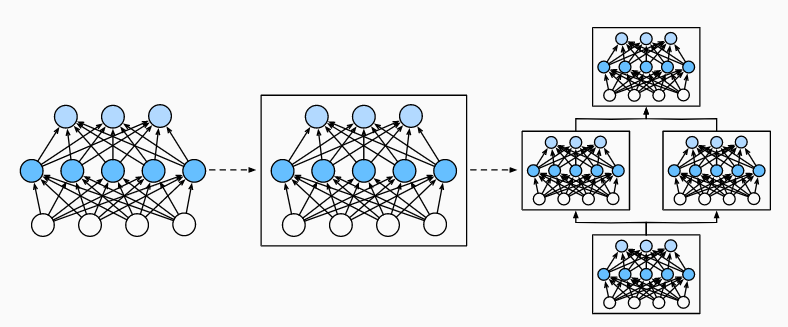

1. 自定义块：每个块必须提供的基本功能
2. 顺序块：Sequential的设计是为了把其他模块串起来
3. 在正向传播函数中执行代码：更大的灵活性时，我们需要定义自己的块，多种组合

In [4]:
# MLP结构回顾
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[ 0.1161, -0.0641, -0.0029,  0.1349,  0.1586,  0.1028, -0.1130,  0.0545,
          0.0067, -0.1147],
        [ 0.1867, -0.1839,  0.0824,  0.1666,  0.2700,  0.1038, -0.1887,  0.0227,
         -0.0803, -0.1503]], grad_fn=<AddmmBackward>)

In [2]:
# 自定义块
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用`MLP`的父类`Block`的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数`params`（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的正向传播，即如何根据输入`X`返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

    
net = MLP()
net(X)

tensor([[-0.0193,  0.2825, -0.1116,  0.3318,  0.1970, -0.2827, -0.3074, -0.0537,
         -0.2524,  0.2343],
        [ 0.0379,  0.3108, -0.0397,  0.3099,  0.2624, -0.0577, -0.3195, -0.0422,
         -0.3036,  0.1488]], grad_fn=<AddmmBackward>)

In [3]:
# 顺序块
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for block in args:
            # 这里，`block`是`Module`子类的一个实例。我们把它保存在'Module'类的成员变量
            # `_modules` 中。`block`的类型是OrderedDict。
            self._modules[block] = block

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X
    
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.1291, -0.2358,  0.0261,  0.1154, -0.1286,  0.2521,  0.0115, -0.1123,
          0.1267, -0.2086],
        [ 0.0319, -0.1362,  0.0175,  0.1139, -0.0960,  0.1531,  0.0953, -0.0651,
          0.0618, -0.0923]], grad_fn=<AddmmBackward>)

In [4]:
# 在正向传播中自定义块，提高灵活性
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变。
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及`relu`和`dot`函数。
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数。
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()
    
net = FixedHiddenMLP()
net(X)

tensor(0.0777, grad_fn=<SumBackward0>)

In [5]:
# 混合搭配各种块
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.2559, grad_fn=<SumBackward0>)